### Project Details
This notebook analyzes and predicts laptop prices using a dataset containing various features such as brand, specifications, and screen details. The workflow includes data cleaning, feature engineering, exploratory data analysis, model training (Random Forest and XGBoost), hyperparameter tuning, and model evaluation.

## Import Libraries

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


##  unzip the file

In [245]:
import zipfile

with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

print("✅ Archive extracted.")


✅ Archive extracted.


## List & Load the CSV File

In [246]:
import os

# List extracted files
for root, dirs, files in os.walk("dataset"):
    for file in files:
        print(file)


laptop_price.csv


In [247]:
import pandas as pd

# Load using proper encoding
df = pd.read_csv("dataset/laptop_price.csv", encoding="latin1")

# Show first 5 rows
df.head()




,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [248]:
df.shape

(1303, 13)

## Data Cleaning

Check dataset info


In [249]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [250]:
df.describe()


,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


 Check missing values

In [251]:
df.isnull().sum()


laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

Duplicate valu

In [252]:
df.duplicated().sum()

np.int64(0)

Convert RAM & Weight to numeric

In [253]:
# Remove 'GB' and convert to integer
df['Ram'] = df['Ram'].str.replace('GB', '', regex=False).astype(int)

# Remove 'kg' and convert to float
df['Weight'] = df['Weight'].str.replace('kg', '', regex=False).astype(float)

# Drop 'laptop_ID' and 'Product' as they are not useful for prediction
df.drop(['laptop_ID', 'Product'], axis=1, inplace=True)

# Show the result
df.head()




,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   int64  
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   float64
 10  Price_euros       1303 non-null   float64
dtypes: float64(3), int64(1), object(7)
memory usage: 112.1+ KB


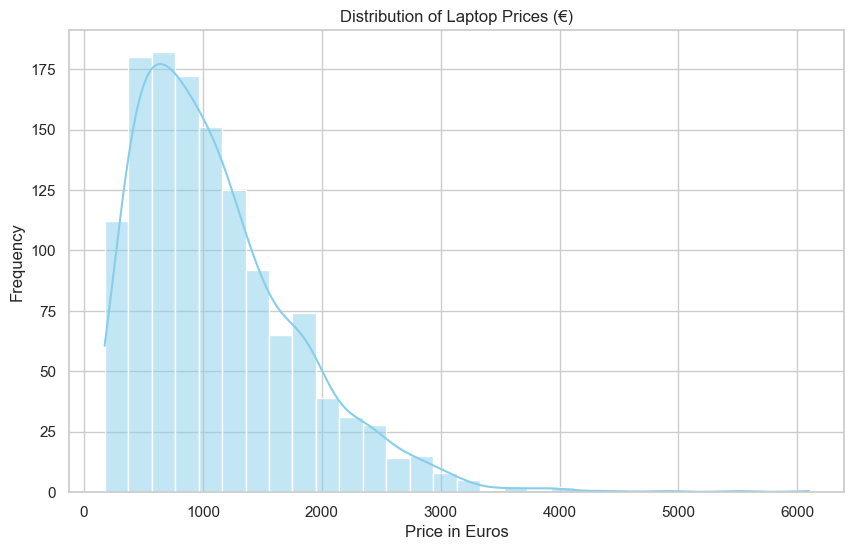

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Plot distribution of laptop prices
plt.figure(figsize=(10, 6))
sns.histplot(df['Price_euros'], kde=True, bins=30, color='skyblue')

plt.title('Distribution of Laptop Prices (€)')
plt.xlabel('Price in Euros')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()




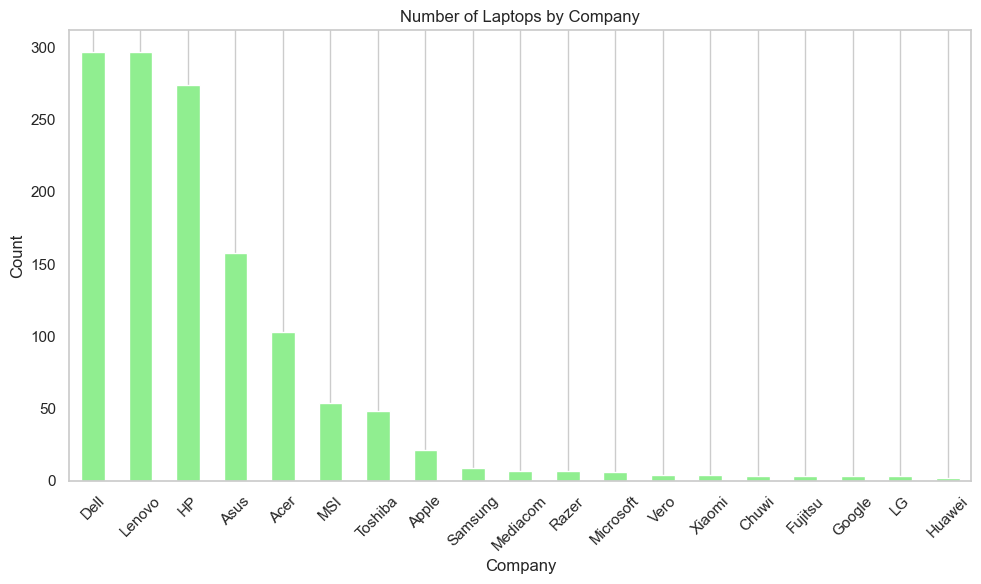

In [256]:
import matplotlib.pyplot as plt

df['Company'].value_counts().plot(kind='bar', figsize=(10, 6), color='lightgreen')
plt.title('Number of Laptops by Company')
plt.xlabel('Company')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


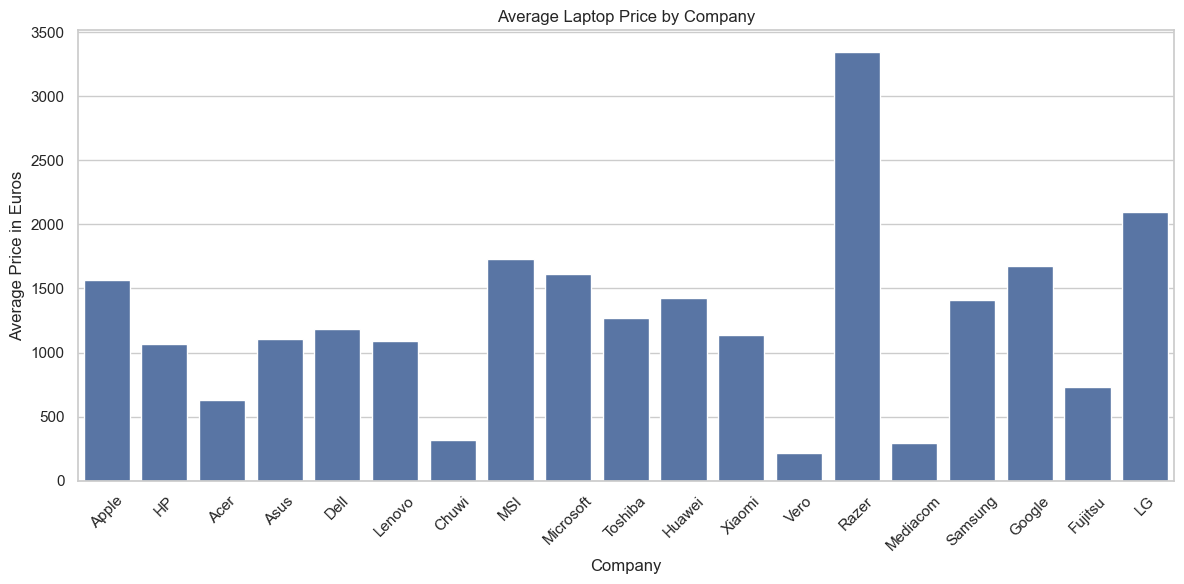

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size and style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create barplot for average price per company
sns.barplot(x='Company', y='Price_euros', data=df, estimator='mean', ci=None)

# Add labels and title
plt.title("Average Laptop Price by Company")
plt.xlabel("Company")
plt.ylabel("Average Price in Euros")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


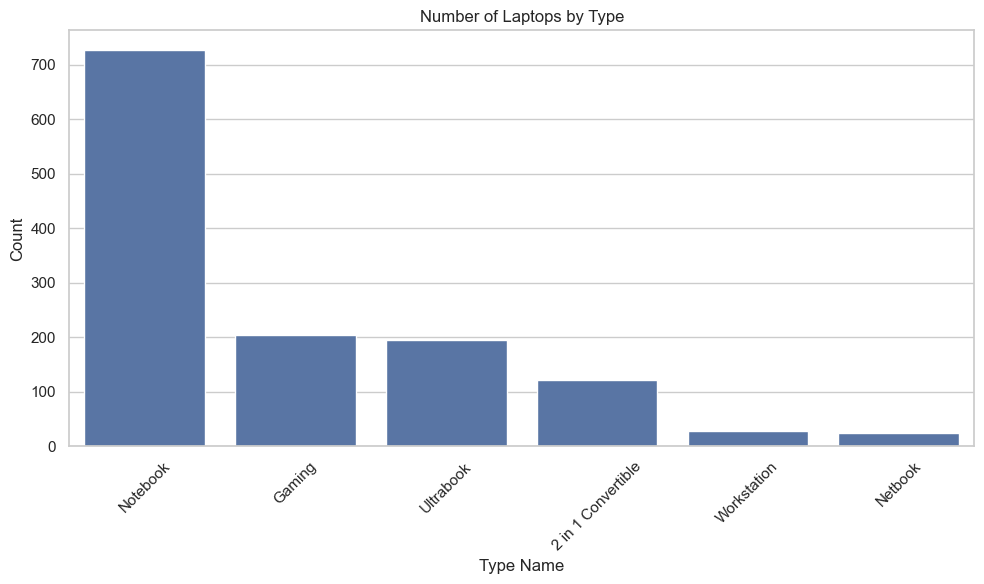

In [258]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size and style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create barplot for count of each TypeName
sns.countplot(data=df, x='TypeName', order=df['TypeName'].value_counts().index)

# Add labels and title
plt.title("Number of Laptops by Type")
plt.xlabel("Type Name")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



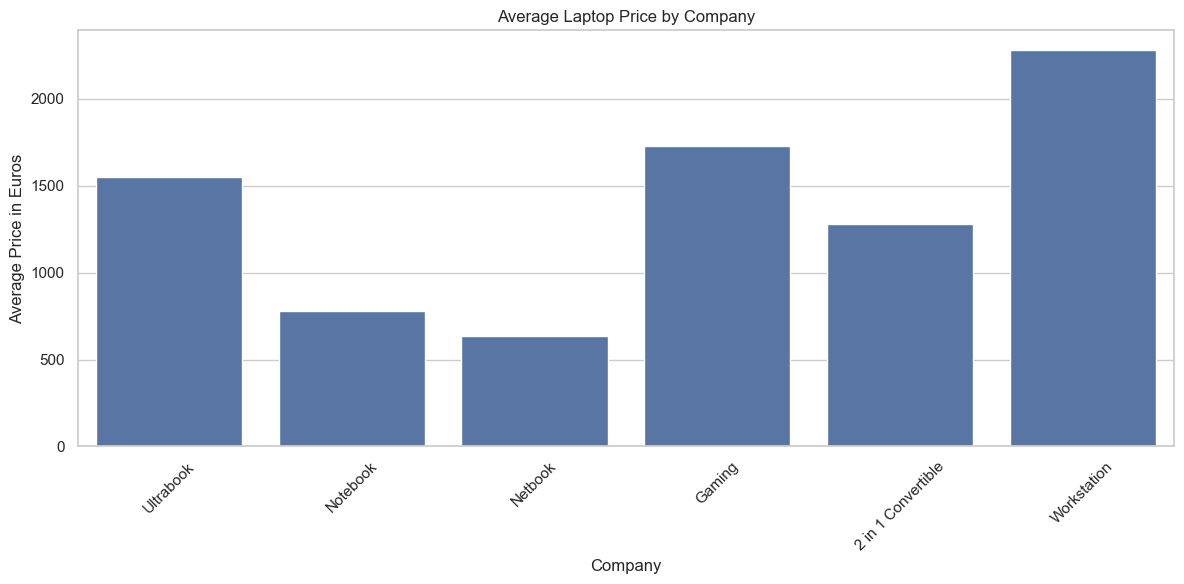

In [259]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size and style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create barplot for average price per company
sns.barplot(x='TypeName', y='Price_euros', data=df, estimator='mean', ci=None)

# Add labels and title
plt.title("Average Laptop Price by Company")
plt.xlabel("Company")
plt.ylabel("Average Price in Euros")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

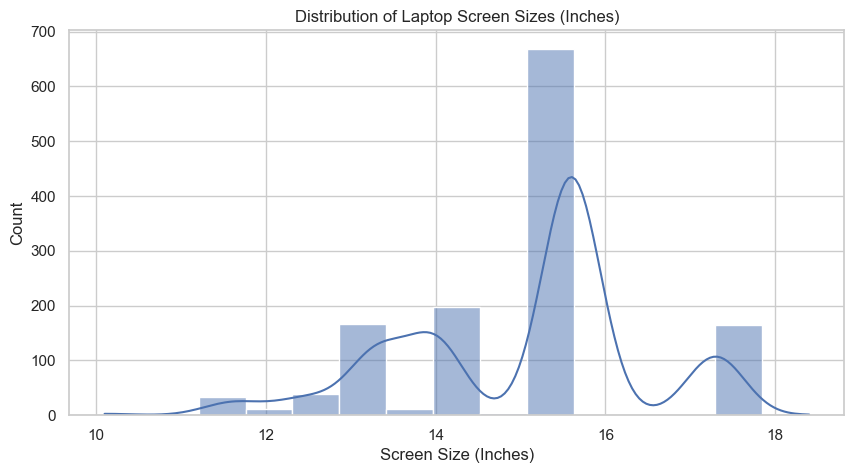

In [260]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(df['Inches'], bins=15, kde=True)

plt.title("Distribution of Laptop Screen Sizes (Inches)")
plt.xlabel("Screen Size (Inches)")
plt.ylabel("Count")
plt.show()


Compare Inches vs. Price

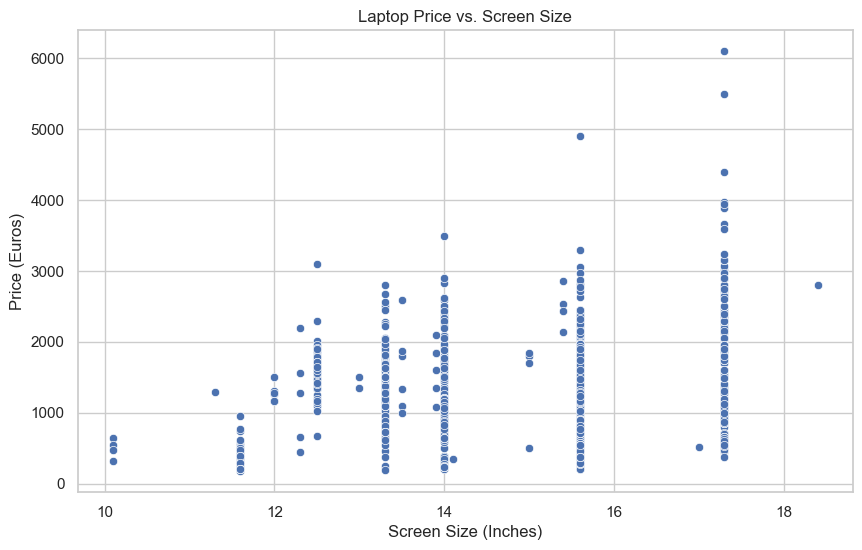

In [261]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Inches', y='Price_euros')

plt.title("Laptop Price vs. Screen Size")
plt.xlabel("Screen Size (Inches)")
plt.ylabel("Price (Euros)")
plt.show()


screen resolutions types

In [262]:
# Count top resolutions
print(df['ScreenResolution'].value_counts())


ScreenResolution
Full HD 1920x1080                                507
1366x768                                         281
IPS Panel Full HD 1920x1080                      230
IPS Panel Full HD / Touchscreen 1920x1080         53
Full HD / Touchscreen 1920x1080                   47
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  15
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160               10
IPS Panel 1366x768                                 7
Touchscreen 2560x1440                              7
4K Ultra HD 3840x2160                              7
IPS Panel Retina Display 2304x1440                 6
IPS Panel Retina Display 2560x1600                 6
Touchscreen 2256x1504                              6
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
IPS Panel Touchscreen 2560x14

In [263]:
df['Touchscreen'] = df['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Touchscreen
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,0
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94,0
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00,0
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45,0
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,0


In [264]:
# Create new column that checks if 'Touchscreen' appears in ScreenResolution
df['TouchScreen'] = df['ScreenResolution'].str.contains('Touchscreen', case=False)

# Convert boolean to string labels for better plot readability
df['TouchScreen'] = df['TouchScreen'].map({True: 'Touchscreen', False: 'Non-Touchscreen'})


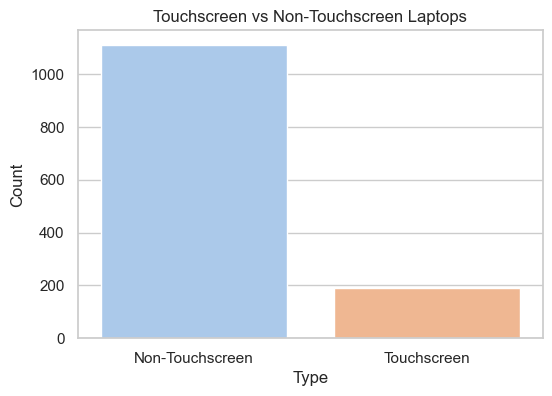

In [265]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='TouchScreen', palette='pastel')

plt.title("Touchscreen vs Non-Touchscreen Laptops")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()


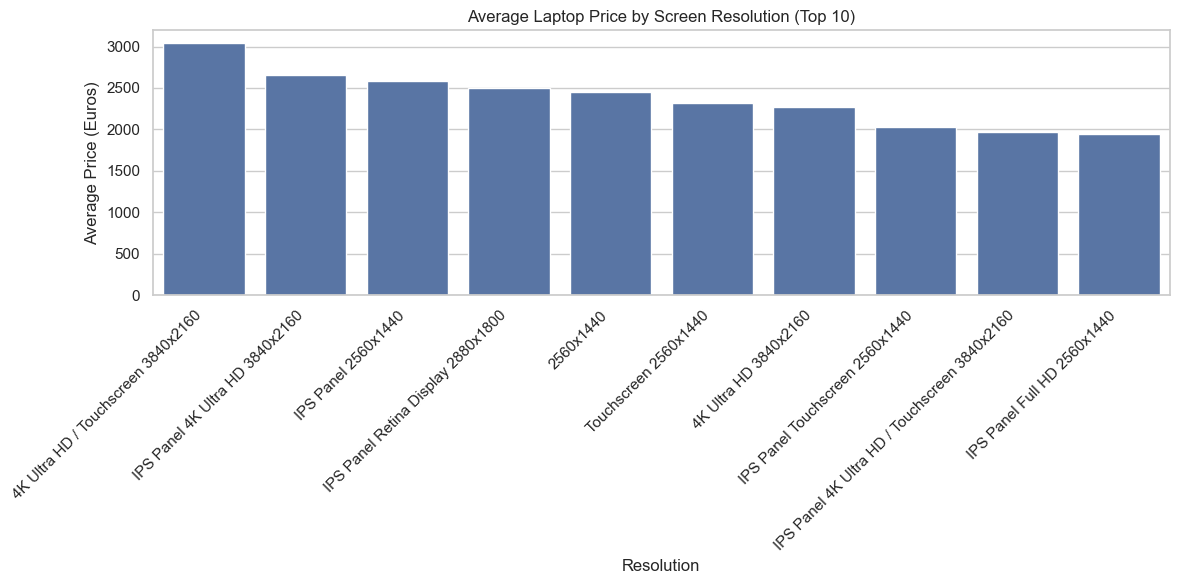

In [266]:
# Group by resolution and get average price
avg_price_by_res = df.groupby('ScreenResolution')['Price_euros'].mean().sort_values(ascending=False).head(10)

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_price_by_res.index, y=avg_price_by_res.values)
plt.xticks(rotation=45, ha='right')
plt.title("Average Laptop Price by Screen Resolution (Top 10)")
plt.xlabel("Resolution")
plt.ylabel("Average Price (Euros)")
plt.tight_layout()
plt.show()


In [267]:
# Extract features from ScreenResolution
df['Touchscreen'] = df['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)
df['IPS'] = df['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)

# Extract screen resolution
resolutions = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)')
df['X_res'] = resolutions[0].astype(float)
df['Y_res'] = resolutions[1].astype(float)
df['PPI'] = ((df['X_res']**2 + df['Y_res']**2)**0.5) / df['Inches']
df.drop(['ScreenResolution'], axis=1, inplace=True)
df.head()


,Company,TypeName,Inches,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Touchscreen,TouchScreen,IPS,X_res,Y_res,PPI
0,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,0,Non-Touchscreen,1,2560.0,1600.0,226.983005
1,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94,0,Non-Touchscreen,0,1440.0,900.0,127.677940
2,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00,0,Non-Touchscreen,0,1920.0,1080.0,141.211998
3,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45,0,Non-Touchscreen,1,2880.0,1800.0,220.534624
4,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,0,Non-Touchscreen,1,2560.0,1600.0,226.983005


 IPS vs Non-IPS Panels

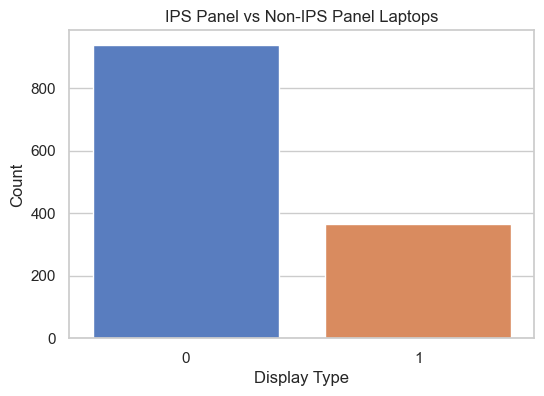

In [268]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='IPS', palette='muted')

plt.title("IPS Panel vs Non-IPS Panel Laptops")
plt.xlabel("Display Type")
plt.ylabel("Count")
plt.show()


IPS and Get Average Price

In [269]:
# Group and calculate average price
avg_price_by_ips = df.groupby('IPS')['Price_euros'].mean()
print(avg_price_by_ips)


IPS
0    1013.756215
1    1406.194027
Name: Price_euros, dtype: float64


 Bar Plot: Average Price by IPS Panel

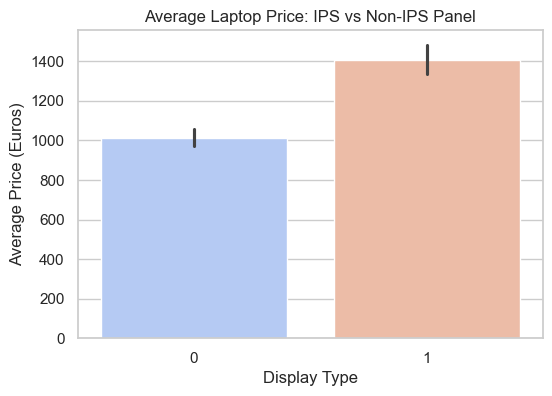

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='IPS', y='Price_euros', estimator='mean', palette='coolwarm')

plt.title("Average Laptop Price: IPS vs Non-IPS Panel")
plt.xlabel("Display Type")
plt.ylabel("Average Price (Euros)")
plt.show()


Clean and Encode CPU, GPU, Memory

In [271]:
df['Memory'].head(10).to_list()




['128GB SSD',
 '128GB Flash Storage',
 '256GB SSD',
 '512GB SSD',
 '256GB SSD',
 '500GB HDD',
 '256GB Flash Storage',
 '256GB Flash Storage',
 '512GB SSD',
 '256GB SSD']

In [272]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()

# Encode all string columns
categorical_cols = df_encoded.select_dtypes(include='object').columns

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

df_encoded.head()



,Company,TypeName,Inches,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Touchscreen,TouchScreen,IPS,X_res,Y_res,PPI
0,1,4,13.3,65,8,4,58,8,1.37,1339.69,0,0,1,2560.0,1600.0,226.983005
1,1,4,13.3,63,8,2,51,8,1.34,898.94,0,0,0,1440.0,900.0,127.677940
2,7,3,15.6,74,8,16,53,4,1.86,575.00,0,0,0,1920.0,1080.0,141.211998
3,1,4,15.4,85,16,29,9,8,1.83,2537.45,0,0,1,2880.0,1800.0,220.534624
4,1,4,13.3,67,8,16,59,8,1.37,1803.60,0,0,1,2560.0,1600.0,226.983005


Train-Test Split

In [273]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('Price_euros', axis=1)
y = df_encoded['Price_euros']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Training samples: 1042
Test samples: 261


 Feature Scaling

In [274]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train Random Forest Regressor

In [275]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Evaluate Model Performance

R² Score: 0.8254035366509028
RMSE: 297.79552526114355


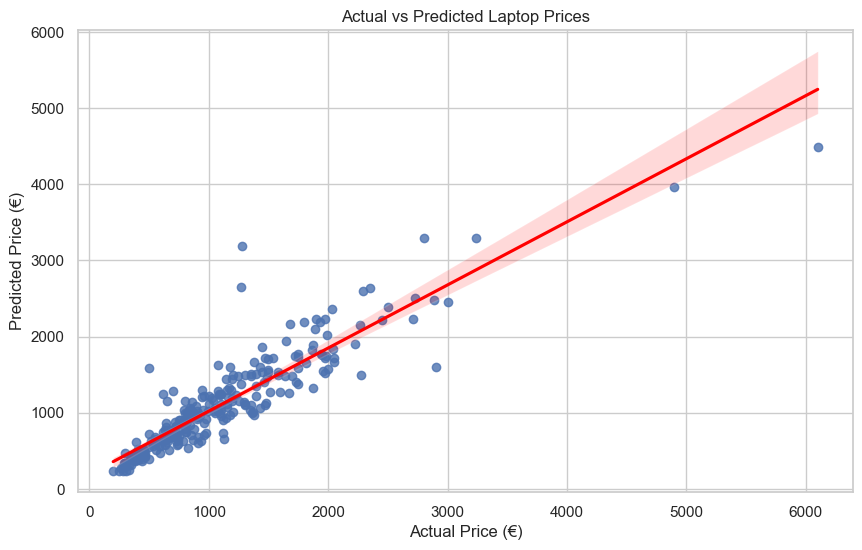

In [276]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test_scaled)

# Evaluation
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Visualization
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"})
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Actual vs Predicted Laptop Prices")
plt.grid(True)
plt.show()


Hyperparameter Tuning with GridSearchCV

In [277]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Set up grid search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid,
                           cv=3,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=2)

# Fit model
grid_search.fit(X_train_scaled, y_train)

# Show best results
print("Best R² Score from GridSearchCV:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# Use best estimator for predictions
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best R² Score from GridSearchCV: 0.8250935063341992
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Evaluate Tuned Model

Tuned R² Score: 0.827712822992034
Tuned RMSE: 295.81958535502196


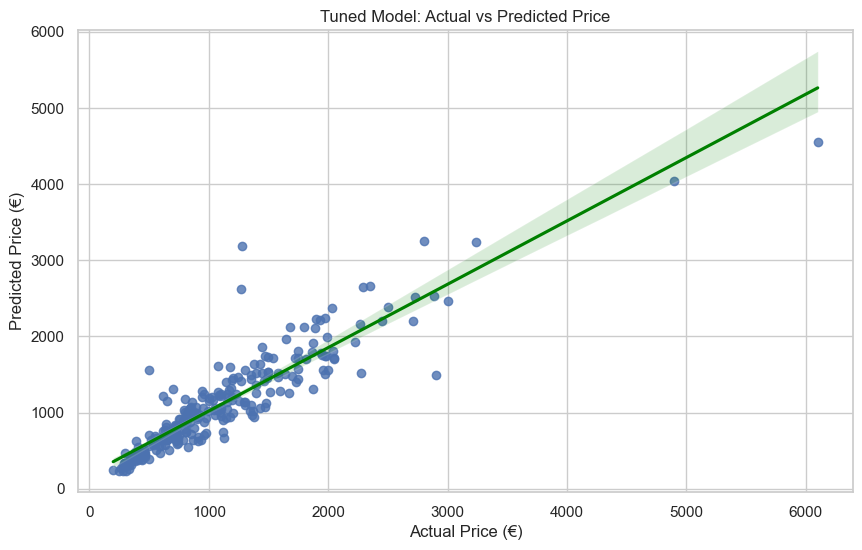

In [278]:
# Predict using best model
y_pred_best = best_model.predict(X_test_scaled)

# Evaluation
print("Tuned R² Score:", r2_score(y_test, y_pred_best))
print("Tuned RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred_best, line_kws={"color": "green"})
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Tuned Model: Actual vs Predicted Price")
plt.grid(True)
plt.show()


In [279]:
import joblib

joblib.dump(best_model, "laptop_price_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

🔢 Tuned R² Score: 0.827712822992034
📉 Tuned RMSE: 295.81958535502196


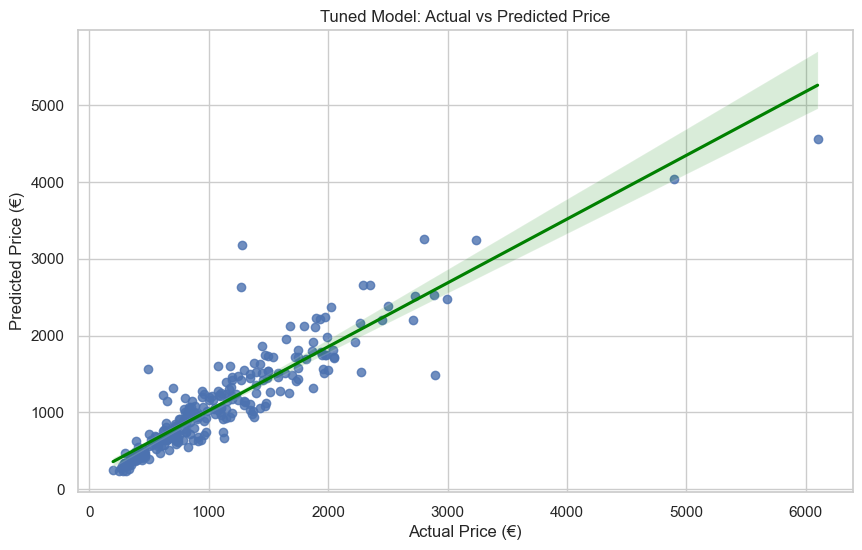

In [280]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict using best model from GridSearchCV
y_pred_best = best_model.predict(X_test_scaled)

# Calculate performance
r2 = r2_score(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))

# Print scores
print("🔢 Tuned R² Score:", r2)
print("📉 Tuned RMSE:", rmse)

# Visualize results
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred_best, line_kws={"color": "green"})
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Tuned Model: Actual vs Predicted Price")
plt.grid(True)
plt.show()


Train and Evaluate XGBoost

🚀 XGBoost R² Score: 0.8132709604417978
🚀 XGBoost RMSE: 307.9685570572505


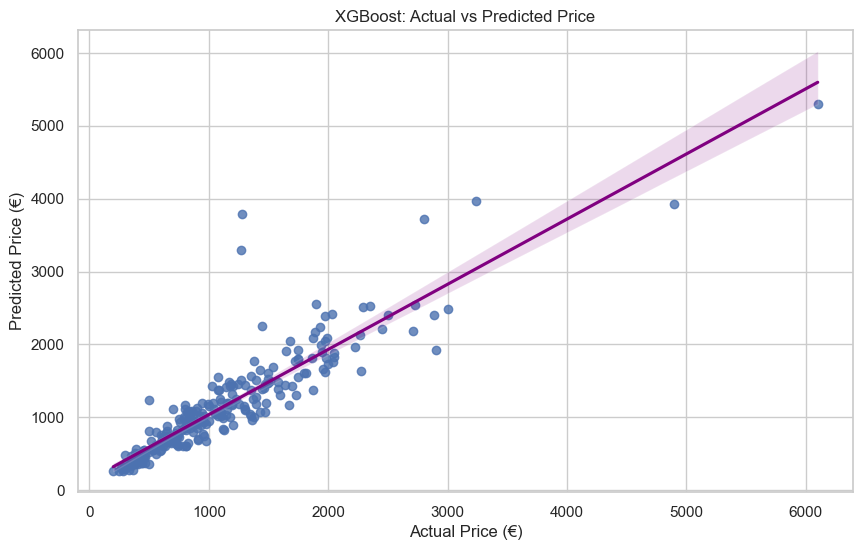

In [281]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Train XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb.fit(X_train_scaled, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test_scaled)

# Metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("🚀 XGBoost R² Score:", r2_xgb)
print("🚀 XGBoost RMSE:", rmse_xgb)

# Plot results
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred_xgb, line_kws={"color": "purple"})
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("XGBoost: Actual vs Predicted Price")
plt.grid(True)
plt.show()


Compare All Models

In [282]:
print("🔁 Random Forest R²:", r2_score(y_test, y_pred))
print("🔥 Tuned RF R²:", r2_score(y_test, y_pred_best))
print("🚀 XGBoost R²:", r2_score(y_test, y_pred_xgb))


🔁 Random Forest R²: 0.8254035366509028
🔥 Tuned RF R²: 0.827712822992034
🚀 XGBoost R²: 0.8132709604417978
